In [1]:
# import libraries
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import torch
from torch import nn
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import copy
import sys
sys.path.append("./src")
from autoencoder import Embedding

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

## Part 3 - Noisy Image to Image

In [2]:
def create_noise(data, n_pix=52):
    flattened = copy.deepcopy(data).view(-1, 28*28)
    size = flattened.size()[0]
    for n in range(size):
        the_pixels = np.random.randint(0, 28*28, size=n_pix)
        pix_vals = np.random.rand(n_pix)
        for p, v in zip(the_pixels, pix_vals):
            flattened[n][p] = v*.75+.25
    return flattened.view(size, 1, 28, 28)

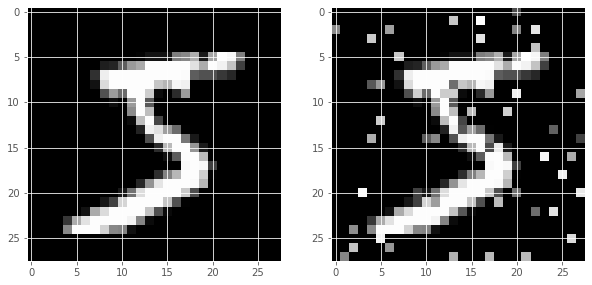

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
data, labels = dataiter.next()

mod_data = create_noise(data)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(data[0].view(28,28), cmap='gray')
ax[1].imshow(mod_data[0].view(28,28), cmap='gray')

In [5]:
# initialize the NN
cleaning_model = Embedding()
print(cleaning_model)

Embedding(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=784, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [6]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.L1Loss()

# specify optimizer
optimizer = torch.optim.SGD(cleaning_model.parameters(), lr=0.05, momentum=0.01)

In [8]:
# number of epochs to train the model
from time import time
n_epochs = 30  # suggest training between 20-50 epochs

cleaning_model.train() # prep model for training

for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch))
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    n = 0
    t = time()
    for data, target in train_loader:
        n+=1
        if n%300==0:
            dt = time() - t
            print("Start batch {}, delta time: {}".format(n, dt))
            t = time()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        mod_data = create_noise(data)
        output = cleaning_model(mod_data)
        target_unfolded = data.view(-1, 28 * 28)
        # calculate the loss
        loss = criterion(output, target_unfolded)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Starting epoch 0
Start batch 300, delta time: 10.318522930145264
Start batch 600, delta time: 10.058314085006714
Start batch 900, delta time: 9.088522911071777
Start batch 1200, delta time: 8.970702171325684
Start batch 1500, delta time: 9.589937210083008
Start batch 1800, delta time: 9.839532136917114
Start batch 2100, delta time: 9.83347201347351
Start batch 2400, delta time: 8.90708875656128
Start batch 2700, delta time: 8.917899131774902
Start batch 3000, delta time: 8.927475929260254
Epoch: 1 	Training Loss: 0.125515
Starting epoch 1
Start batch 300, delta time: 8.886934757232666
Start batch 600, delta time: 8.945320844650269
Start batch 900, delta time: 8.971415996551514
Start batch 1200, delta time: 8.969735860824585
Start batch 1500, delta time: 8.950124025344849
Start batch 1800, delta time: 9.006447076797485
Start batch 2100, delta time: 9.046746253967285
Start batch 2400, delta time: 9.813156127929688
Start batch 2700, delta time: 9.626107931137085
Start batch 3000, delta ti

Start batch 2100, delta time: 8.508453130722046
Start batch 2400, delta time: 8.418593168258667
Start batch 2700, delta time: 8.574843883514404
Start batch 3000, delta time: 8.413766860961914
Epoch: 16 	Training Loss: 0.065451
Starting epoch 16
Start batch 300, delta time: 8.268566846847534
Start batch 600, delta time: 8.257037162780762
Start batch 900, delta time: 8.395165205001831
Start batch 1200, delta time: 8.196115970611572
Start batch 1500, delta time: 2314.972800016403
Start batch 1800, delta time: 9.27856707572937
Start batch 2100, delta time: 11.988623857498169
Start batch 2400, delta time: 12.27695083618164
Start batch 2700, delta time: 13.9081871509552
Start batch 3000, delta time: 12.319139003753662
Epoch: 17 	Training Loss: 0.064479
Starting epoch 17
Start batch 300, delta time: 10.807499170303345
Start batch 600, delta time: 10.487740993499756
Start batch 900, delta time: 1898.7158589363098
Start batch 1200, delta time: 10.351843118667603
Start batch 1500, delta time: 12

In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

cleaning_model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    mod_data = create_noise(data)
    output = cleaning_model(mod_data)
    target_unfolded = data.view(-1, 1, 28 * 28)
    # calculate the loss
    loss = criterion(output, target_unfolded)
    # update test loss 
    test_loss += loss.item()*data.size(0)

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.140578



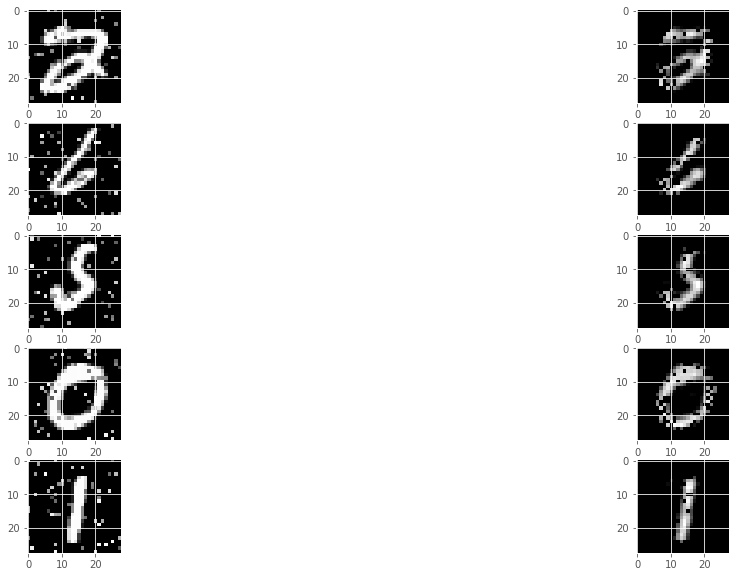

In [10]:
# plot the images in the batch, along with predicted and true labels
fig, ax = plt.subplots(5, 2, figsize=(20, 10))
for idx in np.arange(5):
    ax[idx, 0].imshow(np.squeeze(mod_data.view(20, 28, 28).detach().numpy()[idx]), cmap='gray')
    ax[idx, 1].imshow(np.squeeze(output.view(20, 28, 28).detach().numpy()[idx]), cmap='gray')